In [3]:
from common.logging import create_logger
from pathlib import Path
import pandas as pd
from datasets import single_label_multiclass_annotated_study_design, enrich_annotations, annotations_with_specter_embeddings
from classifier import train_validate_catboost_model
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Fetch the datasets (using David's annotations)

In [2]:

data_dir = Path('/media/wwymak/Storage/coronawhy/nlp_datasets')
annotations_filepath = (data_dir / 'cord19_study_design_labelled' / 'design.csv')
metadata_filepath   = data_dir/'metadata.csv.zip'
processed_article_folder = data_dir / 'v8'/ 'processed_text'
# annotations + metadata from kaggle to get the title + abstract. 
annotations_raw = single_label_multiclass_annotated_study_design(annotations_filepath, metadata_filepath)

In [3]:
annotations_raw.head()

,sha,cord_uid,label,title,abstract,label_string
0,03cda737465b68fbf1a76dafe2e3788961f986be,4a5zy5wu,0,Monitoring Transmissibility and Mortality of C...,Abstract Objectives As a global pandemic is in...,Other
5,059d5acb8af8bd2bedab06b5dcc0510691fe0f1e,31i1k332,0,Laboratory readiness and response for novel co...,Timely detection of novel coronavirus (2019-nC...,Other
7,0760e79585cd85c7e9a59f88188b915955aa3926,iyv86437,0,And now for something completely different: fr...,Infectious diseases have accompanied mankind s...,Other
11,0aff00101d5ccc6592987185ab833f95d842f98b,g5wpa2ee,0,Potentially highly potent drugs for 2019-nCoV,AbstractThe World Health Organization (WHO) ha...,Other
12,0bd443591b5e10934beef050b516afeca6b668fe,3kp3ptbn,0,A simple model to assess Wuhan lock-down effec...,"Since COVID-19 emerged in early December, 2019...",Other


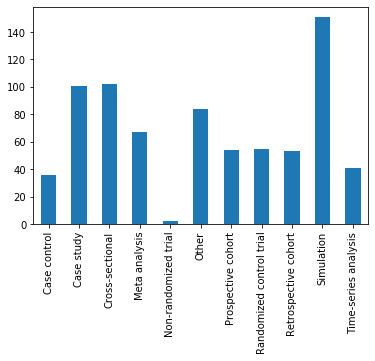

In [4]:
annotations_raw.label_string.value_counts().sort_index().plot.bar()

classification with catboost on annotations title + abstract, using text features

In [5]:
design_labelled_metadata = annotations_raw[['abstract', 'title', 'label']].sample(frac=1.0)
test_set_len = len(design_labelled_metadata) //5
results = []
params = {}
for i in tqdm(range(5)):
    test = design_labelled_metadata.iloc[i * test_set_len : (i+1)* test_set_len]
    train = design_labelled_metadata[~design_labelled_metadata.index.isin(test.index)]
    model, acc, f1, f1_macro, params = train_validate_catboost_model(
        train, test,
        ['abstract', 'title'],
        'label',
        text_features=['abstract', 'title'], params={}, verbose=False)
    results.append({
        "i": i,
        "f1": f1,
        "acc": acc,
        'f1_macro': f1_macro,
    })

results = pd.DataFrame(results)
params_str = ",".join([f"{k}={v}" for k, v in params.items()])
print(pd.DataFrame(results))

  0%|          | 0/5 [00:00<?, ?it/s]2020-04-27 21:49:12,865::INFO::catboost_classifier.py::43  accuracy: 0.7986577181208053
2020-04-27 21:49:12,866::INFO::catboost_classifier.py::44  f1: [0.66666667 1.         0.96551724 0.54545455 0.2        0.72727273
 0.95652174 1.         0.8        0.73972603]
2020-04-27 21:49:12,866::INFO::catboost_classifier.py::45  f1_macro: 0.7601158947300946
 20%|██        | 1/5 [00:12<00:49, 12.25s/it]2020-04-27 21:49:24,904::INFO::catboost_classifier.py::43  accuracy: 0.7181208053691275
2020-04-27 21:49:24,904::INFO::catboost_classifier.py::44  f1: [0.54545455 0.88888889 1.         0.33333333 0.57142857 0.53846154
 0.8        0.94117647 0.68965517 0.74666667]
2020-04-27 21:49:24,905::INFO::catboost_classifier.py::45  f1_macro: 0.7055065187235573
 40%|████      | 2/5 [00:24<00:36, 12.19s/it]2020-04-27 21:49:37,139::INFO::catboost_classifier.py::43  accuracy: 0.7651006711409396
2020-04-27 21:49:37,140::INFO::catboost_classifier.py::44  f1: [0.42857143 1.    

   i                                                 f1       acc  f1_macro
0  0  [0.6666666666666667, 1.0, 0.9655172413793104, ...  0.798658  0.760116
1  1  [0.5454545454545454, 0.8888888888888888, 1.0, ...  0.718121  0.705507
2  2  [0.42857142857142855, 1.0, 0.9523809523809523,...  0.765101  0.698697
3  3  [0.5925925925925926, 0.9285714285714286, 0.875...  0.765101  0.748374
4  4  [0.6470588235294118, 0.9523809523809523, 0.965...  0.798658  0.711310


AS per https://github.com/catboost/tutorials/blob/2c16945f850503bfaa631176e87588bc5ce0ca1c/text_features/text_features_in_catboost.ipynb there are a lot of extra text processing params we can possibly tweak

In [10]:
extra_text_params={
        'dictionaries': [
            'Word:min_token_occurrence=2',
            'BiGram:gram_order=2'
        ],
        'text_processing': [
            'NaiveBayes+Word|BoW:top_tokens_count=2000+Word,BiGram|BM25+Word'
        ]
    }
results_catboost2 = []
for i in tqdm(range(5)):
    test = design_labelled_metadata.iloc[i * test_set_len : (i+1)* test_set_len]
    train = design_labelled_metadata[~design_labelled_metadata.index.isin(test.index)]
    model, acc, f1, f1_macro, params = train_validate_catboost_model(
        train, test,
        ['abstract', 'title'],
        'label',
        text_features=['abstract', 'title'], params=extra_text_params, verbose=False)
    results_catboost2.append({
        "i": i,
        "f1": f1,
        "acc": acc,
        'f1_macro': f1_macro,
    })

results_catboost2 = pd.DataFrame(results_catboost2)
pd.DataFrame(results_catboost2)

  0%|          | 0/5 [00:00<?, ?it/s]2020-04-27 22:00:13,358::INFO::catboost_classifier.py::43  accuracy: 0.7785234899328859
2020-04-27 22:00:13,359::INFO::catboost_classifier.py::44  f1: [0.57142857 1.         1.         0.54545455 0.18181818 0.66666667
 0.91304348 1.         0.80952381 0.74285714]
2020-04-27 22:00:13,359::INFO::catboost_classifier.py::45  f1_macro: 0.7430792396009787
 20%|██        | 1/5 [00:11<00:44, 11.16s/it]2020-04-27 22:00:24,068::INFO::catboost_classifier.py::43  accuracy: 0.7248322147651006
2020-04-27 22:00:24,069::INFO::catboost_classifier.py::44  f1: [0.53333333 0.94444444 1.         0.38095238 0.625      0.5
 0.85714286 1.         0.64285714 0.72727273]
2020-04-27 22:00:24,069::INFO::catboost_classifier.py::45  f1_macro: 0.7211002886002886
 40%|████      | 2/5 [00:21<00:33, 11.03s/it]2020-04-27 22:00:35,575::INFO::catboost_classifier.py::43  accuracy: 0.7583892617449665
2020-04-27 22:00:35,575::INFO::catboost_classifier.py::44  f1: [0.46511628 1.         0.

,i,f1,acc,f1_macro
0,0,"[0.5714285714285715, 1.0, 1.0, 0.5454545454545...",0.778523,0.743079
1,1,"[0.5333333333333333, 0.9444444444444444, 1.0, ...",0.724832,0.721100
2,2,"[0.46511627906976744, 1.0, 0.9523809523809523,...",0.758389,0.711459
3,3,"[0.5, 0.9285714285714286, 0.9333333333333333, ...",0.785235,0.766882
4,4,"[0.6060606060606061, 1.0, 0.9655172413793104, ...",0.791946,0.705949


note that not class 3 ("Non-randomized trial") has very few articles so we might consider removing them from training set

classification wiht annotations + umls

In [14]:
annotations_with_umls = enrich_annotations(annotations_raw, processed_article_folder, extra_features=['UMLS'], sections=['method', 'result', 'abstract'])

100%|██████████| 20/20 [03:13<00:00,  9.68s/it]


In [17]:
method_UMLS = annotations_with_umls.groupby('cord_uid')['method_UMLS'].fillna('').apply(','.join).reset_index()
abstract_UMLS =  annotations_with_umls.groupby('cord_uid')['abstract_UMLS'].fillna('').apply(','.join).reset_index()
result_UMLS =  annotations_with_umls.groupby('cord_uid')['result_UMLS'].fillna('').apply(','.join).reset_index()

In [39]:
annotations_with_umls['abstract_UMLS'] = annotations_with_umls['abstract_UMLS'].apply(lambda d: d if isinstance(d, list) else [])
annotations_with_umls['result_UMLS'] = annotations_with_umls['result_UMLS'].apply(lambda d: d if isinstance(d, list) else [])
annotations_with_umls['method_UMLS'] = annotations_with_umls['method_UMLS'].apply(lambda d: d if isinstance(d, list) else [])


annotations_with_umls.groupby('cord_uid')['method_UMLS'].sum().shape

(746,)

In [26]:
annotations_with_umls.cord_uid.unique().shape

(746,)

In [ ]:
df.groupby(['name','month'])['text'].apply(','.join).reset_index()

In [69]:
annotations_with_umls.columns

Index(['sha', 'cord_uid', 'label', 'title', 'abstract', 'label_string',
       'method_UMLS', 'result_UMLS', 'abstract_UMLS'],
      dtype='object')

using the specter embeddings + catboost

In [31]:
annotations_raw.shape
annotations_with_specter_df = annotations_with_specter_embeddings(annotations_raw,data_dir/ 'cord_19_specter_embeddings_4_17.csv.zip' )
annotations_with_specter_df.shape

(746, 774)

In [32]:
annotations_with_specter_df = annotations_with_specter_df[['abstract', 'title', 'label'] + [f"{i}" for i in range(768)]].sample(frac=1.0)
test_set_len = len(annotations_with_specter_df) //5
results = []
params = {}
for i in range(5):
    test = annotations_with_specter_df.iloc[i * test_set_len : (i+1)* test_set_len]
    train = annotations_with_specter_df[~annotations_with_specter_df.index.isin(test.index)]
    model, acc, f1, f1_macro, params = train_validate_catboost_model(
        train, test,
        [f"{i}" for i in range(768)],
        'label', text_features=None, params={}, verbose=False)
    results.append({
        "i": i,
        "f1": f1,
        "acc": acc,
        'f1_macro': f1_macro,
    })

results = pd.DataFrame(results)
params_str = ",".join([f"{k}={v}" for k, v in params.items()])
print(pd.DataFrame(results))

2020-04-27 22:25:00,632::INFO::catboost_classifier.py::43  accuracy: 0.6711409395973155
2020-04-27 22:25:00,633::INFO::catboost_classifier.py::44  f1: [0.51612903 0.81481481 0.83333333 0.         0.33333333 0.
 0.55555556 0.80851064 0.83333333 0.71428571 0.67605634]
2020-04-27 22:25:00,633::INFO::catboost_classifier.py::45  f1_macro: 0.5532138266581992
2020-04-27 22:25:20,988::INFO::catboost_classifier.py::43  accuracy: 0.6174496644295302
2020-04-27 22:25:20,988::INFO::catboost_classifier.py::44  f1: [0.47368421 0.83333333 0.875      0.58823529 0.         0.42857143
 0.77777778 0.5        0.46153846 0.61702128]
2020-04-27 22:25:20,988::INFO::catboost_classifier.py::45  f1_macro: 0.5555161782460709
2020-04-27 22:25:41,518::INFO::catboost_classifier.py::43  accuracy: 0.6174496644295302
2020-04-27 22:25:41,518::INFO::catboost_classifier.py::44  f1: [0.57894737 0.8        0.82758621 0.         0.26666667 0.14285714
 0.38095238 0.73913043 0.8        0.59459459 0.64516129]
2020-04-27 22:25:4

   i                                                 f1       acc  f1_macro
0  0  [0.5161290322580646, 0.8148148148148148, 0.833...  0.671141  0.553214
1  1  [0.47368421052631576, 0.8333333333333333, 0.87...  0.617450  0.555516
2  2  [0.5789473684210527, 0.8, 0.8275862068965517, ...  0.617450  0.525081
3  3  [0.38461538461538464, 0.7368421052631577, 0.87...  0.651007  0.591311
4  4  [0.4, 0.8648648648648649, 0.8333333333333334, ...  0.637584  0.537067


In [30]:
pd.DataFrame(results)

,i,f1,acc,f1_macro
0,0,"[0.3571428571428571, 0.9375, 0.909090909090909...",0.651007,0.593818
1,1,"[0.4571428571428571, 0.7999999999999999, 0.823...",0.604027,0.506118
2,2,"[0.4666666666666667, 0.6666666666666667, 0.869...",0.657718,0.566968
3,3,"[0.3636363636363636, 0.8666666666666667, 0.75,...",0.671141,0.570249
4,4,"[0.48275862068965514, 0.888888888888889, 0.882...",0.610738,0.567772
